<a href="https://colab.research.google.com/github/dr-richard-barker/image-analysis-software-and-R-codes/blob/master/SpaceChile_phenotyping_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install plantcv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Set the notebook display method
# inline = embedded plots, notebook = interactive plots
%matplotlib inline

In [4]:
# Import libraries
from plantcv import plantcv as pcv 
import numpy as np
import requests
import shutil
import re, os, json

In [26]:
# Download sample images

## CHOOSE STUDY:
# Use the study title for unique study titles or study hash for studies without unique titles
study_title="The SpaceChileChallenge CoSE"
study_hash="651e968eccaf4f4699d15398b08a5e37_5f22c4df22dd4"

# Image downloader

# 1) Download API JSON
api_link = "https://five.epicollect.net/api/export/entries/the-spacechilechallenge-cose?form_ref=651e968eccaf4f4699d15398b08a5e37_5f22c4df22dd4"

file_name = api_link.split("=")[-1]+".json"
if not os.path.isfile(file_name):
  res = requests.get(api_link)
  if res.status_code == 200:
      open(file_name, "wb").write(res.content)
  else:
      print('Image Couldn\'t be retrieved')
else:
  pass

# 2) Parse JSON
with open(file_name, "rb") as f:
  api_json_dict = json.load(f)

print("Studies in Collection:\n(Study Title : Study Hash)\n-----")
for study in api_json_dict["data"]["entries"]:
  print(study["title"] + " : " + study["ec5_uuid"])

print("-----")

# 3) Download images from study

# Download loop
for study in api_json_dict["data"]["entries"]:
  if (study["title"] == study_title) or (study["ec5_uuid"] == study_hash):
    for key in study:
      if (isinstance(study[key], str)) and ("https://" in study[key]):
        img_file_name = study[key].split("=")[-1]
        if not os.path.isfile(img_file_name):
            r = requests.get(study[key], stream=True)
            if r.status_code == 200:
              with open(img_file_name, "wb") as f:
                shutil.copyfileobj(r.raw, f)
                print('Image sucessfully Downloaded: ',img_file_name)
            else:
              print('Image Couldn\'t be retrieved')
        else:
          print(f"Image {img_file_name} already retrieved.")



Studies in Collection:
(Study Title : Study Hash)
-----
Martinez Chimayo : 4757a100-2fd8-11ed-a144-63aff3f1ca36
Espanola Improved Greenworks lab 2021 pointy : 0661ac70-f97f-11ec-bc91-2fb7af65c4a5
N/A : f2fa04e0-ed79-11ec-92bd-63399e9b5711
skip` skip : 091db100-e66c-11ec-91fe-0779d8c042f8
n/a : c3981a90-e66a-11ec-aea1-49f9d2e91df5
skip : 380315c0-e35e-11ec-a8e7-edd995e861cb
skip : f68a41e0-e344-11ec-ac2c-c192b4f7841d
skip skip : f36d2360-e344-11ec-9f51-0b7b8ee63647
skip : 46766150-e27f-11ec-8d7a-4b67bee1636d
. no : d68f6080-e27e-11ec-a89c-2bef586b4c11
skip : d430fe20-e27e-11ec-9d87-fb3a96ce9706
skip skip : ad8a6e50-e27e-11ec-8dd8-9f5e35b8e1f2
    : 6dc115d0-e27e-11ec-9b8e-f5d451626028
N/A N/A : 6d2fab40-e27e-11ec-9f1f-338e3aa3738d
    : 3a9b84b0-e27e-11ec-b9e3-61cef9deb9d2
skiop : 264649a0-e27e-11ec-a267-0363e931780d
  : 1911db00-e27e-11ec-b9dd-23b88ade6f65
N/A N/A : 13e98330-e27e-11ec-a78b-41e363ab5fec
skip : 651e80d0-e27d-11ec-926b-85267ee490ff
yes e : 03001850-e27d-11ec-9a2f-9da4b8df

In [27]:
####
#1| Change 'image_path' to another file path
####
image_path = "4757a100-2fd8-11ed-a144-63aff3f1ca36.jpg"

In [28]:
class options:
    def __init__(self):
        self.image = image_path
        self.debug = "plot"
        self.writeimg = False
        self.result = "plant_analysis_results.txt"
        self.outdir = "."

In [29]:
# args holds the input variables
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

# Set plotting size (default = 100)
pcv.params.dpi = 100

# Increase text size and thickness to make labels clearer
# (size may need to be altered based on original image size)
pcv.params.text_size = 10
pcv.params.text_thickness = 20

In [30]:
# Inputs:
#   filename = Image file to be read in 
#   mode     = How to read in the image; either 'native' (default), 
#              'rgb', 'gray', 'csv', or 'envi'
img, path, filename = pcv.readimage(filename=args.image)

RuntimeError: ignored

In [ ]:
# Functions for handling multiple channel masks

def binary_mask_channel(img, channel, method, thresh_val, max_val, obj_type):
	"""
	Single expandable function for handling channel output
	"""
	# Channel references
	hsv = {"H", "S", "V"}
	lab = {"L", "A", "B"}
	# Create gray image for binarization
	if channel.upper() in lab:
		gray_img = pcv.rgb2gray_lab(
			rgb_img=img, 
			channel=channel
			)
	elif channel.upper() in hsv:
		gray_img = pcv.rgb2gray_hsv(
			rgb_img=img, 
			channel=channel
			)
	# Create binary image using specified type
	if method == "binary":
		bin_map = pcv.threshold.binary(
			gray_img=gray_img, 
			threshold=thresh_val, 
			max_value=max_val, 
			object_type=obj_type
			)
	elif method == "otsu":
		bin_map = pcv.threshold.otsu(			
			gray_img=gray_img, 
			max_value=max_val, 
			object_type=obj_type
			)
	else:
		pass
	return bin_map

def pcv_mask_logic_op(mask1, mask2, boolean):
	if (boolean.upper() == "AND"):
		return pcv.logical_and(mask1, mask2)
	elif (boolean.upper() == "OR"):
		return pcv.logical_or(mask1, mask2)
	elif (boolean.upper() == "XOR"):
		return pcv.logical_xor(mask1, mask2)

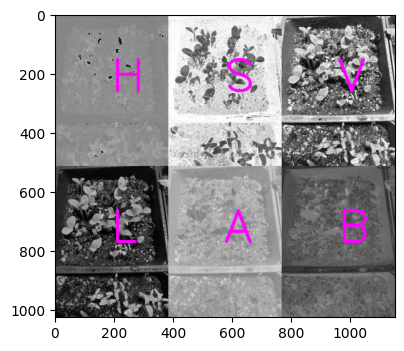

In [ ]:
# Inputs:
#   rbg_img = original image
#   original_img = whether to includ the RGB image in the display: 
#                  True (default) or False
colorspaces = pcv.visualize.colorspaces(rgb_img=img, original_img=False)

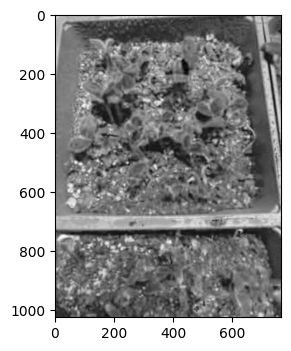

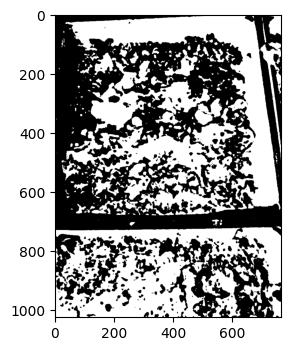

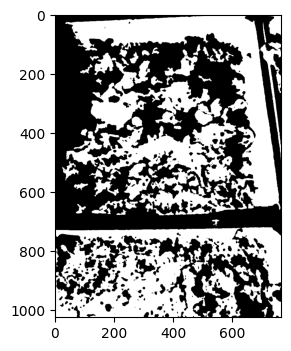

In [ ]:
####
#2| Configure options for creating binary mask
####

# Choose above color channels to use in binary masking
# Options: ("h", "s", "v", "l", "a", "b")
# Ex: ["s","l"]
channels_input = ["a"]

# Choose binarization methods 
#("binary" or "otsu" for Binary Threshold or Otsu Auto Thresholding)
# Ex: ["otsu", "binary"]
methods_input = ["otsu"]

# Set threshhold value
# Note: Not used for otsu, but 'None' required if otsu is used
# Options: Integers 0 - 255
# Ex: [None, 127]
threshholds_input = [None]

# Set max color value
# NOTE: Changing this value not recommended
# Options: Integers 0 - 255
# Ex: [255, 255]
max_color_input = [255]

# Set object color
# Useful to ensure final mask shows plants as white on a black background
# Ex: ["dark", "light"]
object_color_input = ["dark"]

# Boolean combinations of masks
# Number of boolean operators should be one less then previous input lists
# Options: ["AND", "OR", "XOR"]
# Ex: ["AND"]
boolean_combination_input = []

# Set fill amount
# Removes non-target noise from background
# Ex: 200
fill_value_input = 200

## END USER INPUTS

# Create binary mask
## DO NOT CHANGE

final_bin_mask = binary_mask_channel(
    img, 
    channels_input[0], 
    methods_input[0], 
    threshholds_input[0],
    max_color_input[0], 
    object_color_input[0]
)

if len(channels_input) > 1:
  for i in range(1,len(channels_input)):
    working_mask = binary_mask_channel(
    img, 
    channels_input[i], 
    methods_input[i], 
    threshholds_input[i],
    max_color_input[i], 
    object_color_input[i])
    
    final_bin_mask = pcv_mask_logic_op(
        final_bin_mask, 
        working_mask, 
        boolean=boolean_combination_input[i-1])

bin_mask_fill = pcv.fill(bin_img=final_bin_mask, size=fill_value_input)


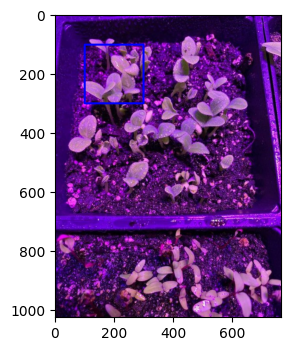

In [ ]:
####
#3| Configure ROI Position
#### 

roi_contour, roi_hierarchy = pcv.roi.rectangle(
    img=img, 

    # Position of upper left corner
    x=100, y=100,

    # Height and Width of the ROI rectangle
    h=200, w=200
    )


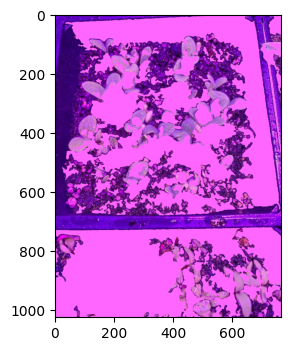

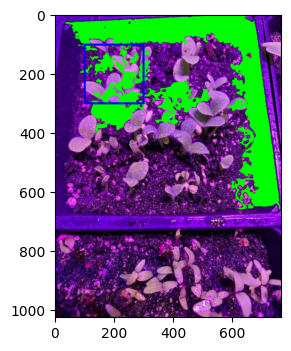

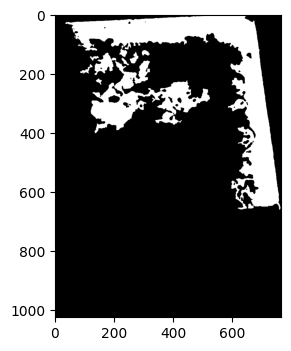

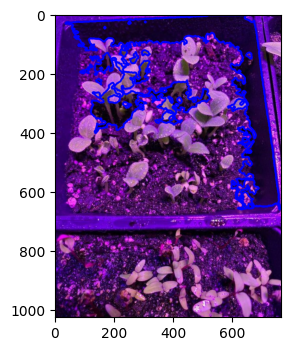

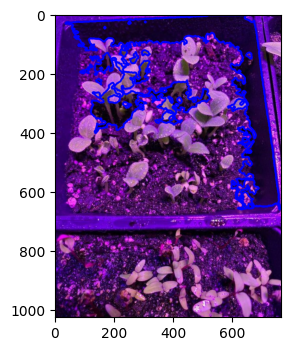

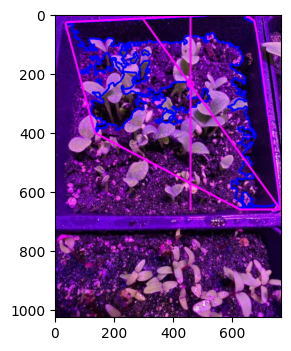

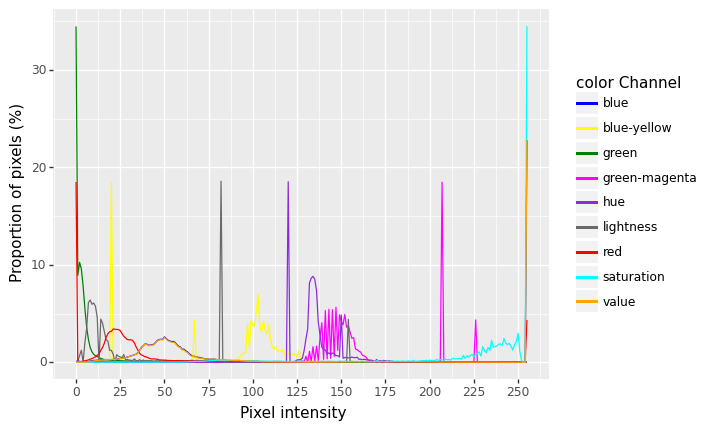

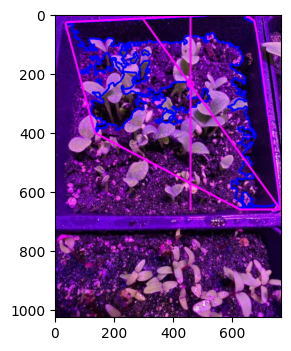

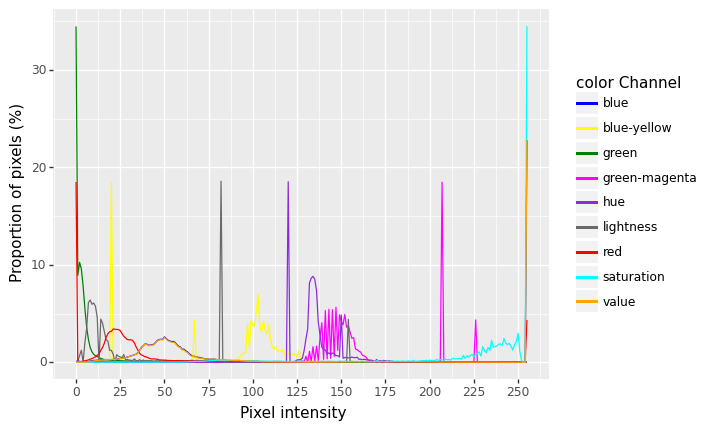

In [ ]:
####
#4| Run Analysis
####

# Inputs:
#   img  = input image
#   mask = a binary mask used to detect objects
obj, obj_hierarchy = pcv.find_objects(img=img, mask=bin_mask_fill)

plant_contours, plant_hierarchy, mask, area = pcv.roi_objects(img=img, 
                                                                  roi_contour=roi_contour, 
                                                                  roi_hierarchy=roi_hierarchy, 
                                                                  object_contour=obj, 
                                                                  obj_hierarchy=obj_hierarchy, 
                                                                  roi_type="partial")

plant_obj, plant_mask = pcv.object_composition(img=img, contours=plant_contours, hierarchy=plant_hierarchy)

img_copy=np.copy(img)
img_copy = pcv.analyze_object(img=img_copy, obj=plant_obj, 
                                      mask=plant_mask, label=f"plant1")
color_img = pcv.analyze_color(rgb_img=img_copy, 
  mask=plant_mask, 
  hist_plot_type=None, 
  label=f"plant1_color")

pcv.plot_image(img_copy)
pcv.plot_image(color_img)

# Inputs:
#   filename  = filename for saving results
#   outformat = output file format: "json" (default) hierarchical format
#                                   or "csv" tabular format
pcv.outputs.save_results(filename=args.result, outformat="csv")